# Notebook walkthrough of ML powered Scalable Binary/Tertiarty Alloy Catlyst optimization/discovery 

Scientific Relevance:

This notebook uses a neural network to design the optimal local chemical environment of a Cu based Binary/Tertiary Alloy Catalyst. This framework is scalable and presents a viable method to discover increasingly complex structures from simpler building blocks.
The specific catalytic system of interest in this work are Cu Binary Alloy Catalysts (BACs) for targetted C2+ products. At the end of this notebook, you will be able to do the following:

<div style="text-align: left; font-size: 22px; color: #224CA0;">
    <strong>1. Discover optimal compositions of BACs and Extract Trends</strong>
</div>

<p align="center" width="10%">
    <img width="70%" src="images/i1.png"> 
</p>

<div style="text-align: left; font-size: 22px; color: #224CA0 ;">
    <strong>2. Design increasingly complex systems with a bottom up approach </strong>
</div>

<p align="center" width="10%">
    <img width="60%" src="images/i2.png"> 
</p>

<div style="text-align: left; font-size: 16px; color: #224CA0 ;">
    <strong> Code Architecture Note: </strong>
</div>

This notebook employs 2 main classes for the ML and Optimization components of this notebook. Please see the 'helpers' script for specific algorithms used.

This walkthrough discusses the steps to import a pre-trained neural network, predict theoretical structures, optimize these structures and automatically generate a VASP readable POSCAR for DFT calculations for both 2 element and 3 element alloys

In [1]:
#Package Imports
from ase.visualize import view

#Import this package if you want to silence deprecation warnings/formating
import warnings
warnings.filterwarnings("ignore")

#From helpers.py file (help functions)
import helpers

# Step 1: Initialize Model_importer class to handle all the ML prep/pre-processing work
>**Class: Model_importer** must load with pathway for saved dataset and model

>**Function 1.1: Import_data** no inputs. Imports training/val/test data.

>**Function 1.2: Import_model** no inputs. Imports model parameters.

>**Function 1.3: model_performance** Evaluate model accuracy and visualize a parity plot.<br>
model : ( TF ) trained TF model object
<br>
X_train/X_test/Y_train/Y_test : ( np array ) Training/test sets
<br>
save_img : ( bool ) save parity plot img 

2023-07-27 17:42:35.372015: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 17:42:35.415885: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open saved_NN_parameters: Failed precondition: saved_NN_parameters; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2023-07-27 17:42:35.480549: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


MAE train:  0.0588 eV
MAE test :  0.0962 eV


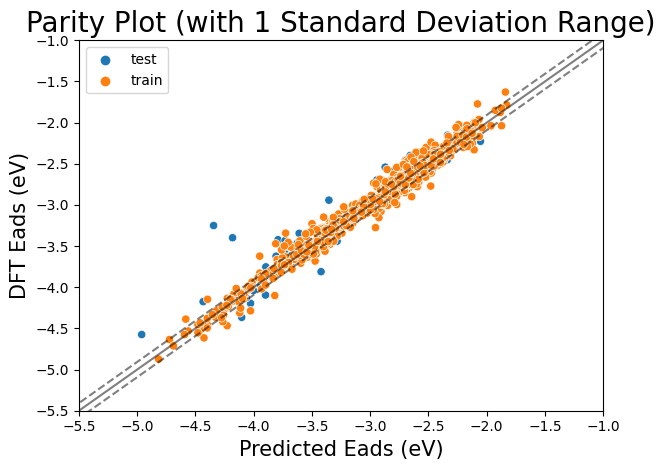

In [3]:
#Initialize Model_importer class to handle TF objects and Pandas dataframes
model_tools = helpers.Model_Importer(data_path='saved_dataset.npy',
                                     model_save_path='saved_NN_parameters',
                                     feature_count=52)

#Import Train/val/test sets solely for parity plot visualization (optional)
X_train,X_val,X_test,Y_train,Y_val,Y_test = model_tools.import_data()

#Import model weights/bias 
model = model_tools.import_model()

#Visualize model performance and print MAE of test/train error 
MAE = model_tools.model_performance(model,X_train,X_test,Y_train,Y_test, save_img=True)

as seen below, this level of accuracy is good based on the wide range of adsorption energies and unique BACs the dataset is composed of. This is largely thanks to the Nied descriptor, a novel quantum descriptor developped by our group and Dr. Z.W Chen.

<p align="center" width="10%">
    <img width="60%" src="images/dists.png"> 
</p>

<div style="text-align: left; font-size: 16px; color: #224CA0 ;">
    <strong> Remark About Feature Engineering: </strong>
</div>

The feature engineering process is outlined below but not explicitly included to keep this notebook a reasonable length. For code on how to perform this type of atomic embedding, please see my repository on ML powered mechanistic insight techniques (https://github.com/gariepyz/Neural-Network-Decomposition-Technique/tree/main)
The 'feature_engineering' function was used to embed this DFT dataset

![Catalyst Discovery Visual](images/feature_eng.png)

This technique allows the model to gain explicit information on the unique electronic surface of BAC/TACs. Based on Deeper DFT research, local chemical environment plays a key role in electron cloud stabilization of bidentate intermediates at all adsorption energies as seen below.

<p align="center" width="10%">
    <img width="70%" src="images/chgd.png"> 
</p>

Furthermore, this basic feature engineering strategy provides excellent accurracy using the proper descriptors. Our lab uses the un-paired d orbital electrons <strong>(Nied)</strong> of an atom as a key indicator which correlates very strong to the predicted energies

<p align="center" width="10%">
    <img width="40%" src="images/nied.png"> 
</p>

The large peaks around -2.8 eV is an artifact of the random structure generation method (Generate_Structures_2n). Atoms were randomnly replaced but in the small chance no atoms are replaced, you end up with a Pure Cu slab which is known to have an Eads around this value.

# Step 2: Initialize Generator class for high-throughput binary alloy discovery
>**Class: Structure_Generator** Must initialize with dictionnary and trained model
<br>
Descriptors : ( dictionnary ) descriptors used to embed atoms.
<br>
model : ( TF ) trained TF model object

>**Function 2.1: Generate_structures_2n** Generate random structures and evaluate catalytic performance.
<br>
Alloying_element (str) - element you would like to alloy with Cu save (bool) save structures to JSON if True.
<br>
count : (float) number of random structures to generate (default 100)
<br>
save : ( bool ) save generated adsorption energy and structures or not

>**Function 2.2: Generate_stats** Quick summary of generated structures.
<br>
b2 : ( list ) predicted adsorption energies from generated structures

>**Function 2.3: Get_optimal_structure** Extract top performing generated structure.
<br>
b2 : ( list ) predicted adsorption energies from generated structures
<br>
b3 : ( list ) predicted structures associated with a given adsorption energy from generated structures
<br>
Alloy_element : ( list ) Element you wish to alloy

>**Function 2.4: New_design_2n** Generate VASP readable geometry file of a Binary Alloy Catalyst substrate.
<br>
idx_2n : ( list ) index of a given generated structure
<br>
Alloying_element : ( str ) Element you wish to alloy
<br>
save : ( bool ) save ASE atoms object of optimized structure or not

Generating Rh BACs...
2n Structure Gen. Runtime (s): 7.973671197891235
Mean: -3.18532
Range: 1.99233
Best Ads: -2.32072


<Popen: returncode: None args: ['/Users/zach/opt/anaconda3/envs/ml_course/bi...>

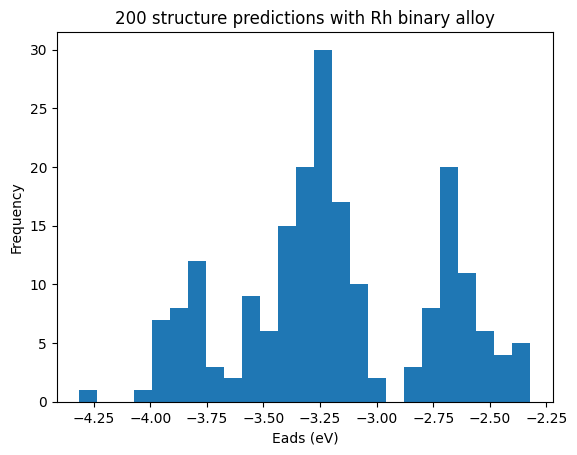

In [4]:
#You have to generate a dictionnary of chemical descriptors you would like to evaluate.
#Default is Group, Period, EN, Un-paired d orbital electron count
Descriptors = {
     'Cu':[4,11,1.90,0],
     'Au':[6,11,2.54,0],
     'Ag':[5,11,1.93,0],
     'Pt':[6,10,2.28,1],
     'Pd':[5,10,2.20,0],
     'Ir':[6,9,2.20,3],
     'Os':[6,8,2.20,4],
     'Ru':[5,8,2.20,3],
     'Rh':[5,9,2.28,2]} 

#Specify the element you want to alloy with Cu and optimize.
#Training set posses the following atoms you can choose from:
# Au, Ag, Pt, Pd, Ir, Os, Ru, Rh
Alloying_element = 'Rh'

#Initialize Structure_Generator class to handle optimization and discovery phases with ease
Generator = helpers.Strucutre_Generator(dictionnary = Descriptors,
                                        model = model,
                                        feature_count = 52,
                                        nearest_atoms_considered = 13)

# Perform Alloy discovery through random structure generation. Default count is 100, 1000 was used for the publication
b1,b2,b3 = Generator.generate_structures_2n(Alloying_element,count=200,save=False)

#Quick summary of the generated results
Generator.get_generation_stats(b2)

#Extract the optimal structures from the generated results
optimization_2n,idx_2n = Generator.get_optimal_structure(b2,b3,[Alloying_element])

#Convert the optimized structure in an ASE atoms object for extraction or inspection
BAC = Generator.new_design_2n(idx_2n,
                               Alloying_element,
                               save=False)

#Comment this line if do not want a 3D view of the generated slab
view(BAC)

<div style="text-align: left; font-size: 16px; color: #224CA0 ;">
    <strong> Remark About Optimization and determination of 'optimal' structures: </strong>
</div>

As seen below, this ML powered optimization is based solely off of COCOH* adsorption energy. The reaction energetics for the bidentate adsorption of dual CO* molecules correlates strongly to this factor and can be used as a design principle for structure generation. 

<p align="center" width="10%">
    <img width="75%" src="images/i3.png"> 
</p>

# Step 3: Initialize Generator class for high-throughput tertiary alloy discovery

>**Function 3.1: Generate_structures_3n** Generate random 3 element structures and evaluate catalytic performance. inputs: e1/e2 (str) - element you would like to alloy with Cu, save (bool) save structures to JSON if True.

>**Function 3.2: Generate_stats** Quick summary of generated structures.
<br>
b2 : ( list ) predicted adsorption energies from generated structures

>**Function 3.3: Get_optimal_structure** Extract top performing generated structure.
<br>
b2 : ( list ) predicted adsorption energies from generated structures
<br>
b3 : ( list ) predicted structures associated with a given adsorption energy from generated structures
<br>
Alloy_element : ( list ) Element you wish to alloy

>**Function 3.4: New_design_3n** Generate VASP readable geometry file of a Tertiary Alloy Catalyst substrate.
<br>
idx_3n : ( list ) index of a given generated structure
<br>
Alloying_element : ( list ) Elements you wish to alloy
<br>
save : ( bool ) save ASE atoms object of optimized structure or not

<div style="text-align: left; font-size: 16px; color: #224CA0 ;">
    <strong> Using the previous step as a way to evaluate and discover good candidates, we can build upon these 2 element systems by combining promising elements to form 3 element systems. These systems can be parsed and optimized in a similar fashion to the 2 element case </strong>
</div>

<p align="center" width="10%">
    <img width="40%" src="images/2to3.png"> 
</p>

In [5]:
#Specify the 2 elements you would like to alloy with Cu
Tertiary_element_1 = 'Au'
Tertiary_element_2 = 'Ag'

#Similar to Step 2, we have to generate structures for evaluation/prediction
t1,t2,t3 = Generator.generate_structures_3n(Tertiary_element_1,
                                            Tertiary_element_2,
                                            count=100,
                                            save=False)

#Quick summary of the generated results
Generator.get_generation_stats(t2)

#Extract the optimal structures from the generated results
optimization_3n,idx_3n = Generator.get_optimal_structure(t2,
                                                         t3,
                                                         [Tertiary_element_1,Tertiary_element_2])

#Convert the optimized structure in an ASE atoms object for extraction or inspection
_,TAC = Generator.new_design_3n(Tertiary_element_1,
                                  Tertiary_element_2,
                                  optimization_3n,
                                  save=True,
                                  formatting='espresso-in')

#Comment this line if do not want a 3D view of the generated slab
view(TAC)

Generating Au/Ag TACs...
3n Structure Gen. Runtime (s): 8.189411163330078
Mean: -2.45922
Range: 1.04245
Best Ads: -1.77504


<Popen: returncode: None args: ['/Users/zach/opt/anaconda3/envs/ml_course/bi...>

<div style="text-align: left; font-size: 16px; color: #224CA0 ;">
    <strong> This notebook also provides a visualize_slabs function to display the optimized structure. If you only performed one of the optimization, comment that line out and it will display the default Cu slab instead  </strong>
</div>

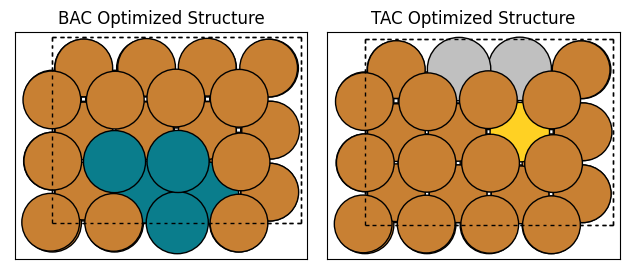

In [6]:
#Visualize the optimized BAC,TAC or both
Generator.visualize_slabs(optimal_BAC=BAC,
                          optimal_TAC=TAC)

<div style="text-align: left; font-size: 16px; color: #224CA0 ;">
    <strong> By generating 1000 structures, we can see some trends about the general influence each element has on C2 product targetting through its adsorption energy impact on COCOH* </strong>
</div>

<p align="center" width="10%">
    <img width="70%" src="images/3n_gen.png"> 
</p>

Thanks to the descriptor embedding technique used, This bottom up approach is highly scalable. The primary limiting factor is ML predictive reliability. Going from 2 element to 3 element prediction dropped the MAE by ~45% and attempting to extrapolate to 4 element systems likely would not be accurate due to the entropic contributions seen in higher element compositions

On a log scale, the accuracy scaling of a NN can be expected to be linear as seen below. This suggests the 1600 datapoints allows the model to reach sufficiently close to the accuracy ceiling using reasonable computational resources 

<p align="center" width="10%">
    <img width="60%" src="images/scaling.png"> 
</p>